<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from helpers.helper_functions import *
from helpers.helper_classes import *
import lightgbm as lgb
from sklearn import preprocessing
import timeit

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

In [2]:
# # Load data
df_train = pd.read_parquet('../data/training_set.parquet', engine = 'auto')
#df_train = df_train[df_train['srch_id'] < 10000]
df_test = pd.read_parquet('../data/test_set.parquet', engine = 'auto')

<h1>Data prep<h1\>

In [3]:
def make_score(df):
    df.loc[:, 'score'] = np.zeros(len(df))
    df.loc[df['click_bool'] == 1, 'score'] = 1
    df.loc[df['booking_bool'] == 1, 'score'] = 5
    return df

# Add features for hour, day and month.
def date_time(df):
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['hour'] = df['date_time'].dt.hour
    df['day'] = df['date_time'].dt.day
    df['month'] = df['date_time'].dt.month
    df['day_of_week'] = df['date_time'].dt.weekday
    df['is_weekend'] = df['date_time'].dt.weekday.isin([5,6]).astype(int)
    df = df.drop('date_time', axis=1)
    return df

def remove_cols(df, cols):
    return df.drop(cols, axis=1)

def remove_cols_nan(df, limit):
    for col in df.columns:
        if len(df[col]) * limit < df[col].isna().sum():
            df = df.drop(col, axis=1)
    return df

# Add column with a ranking for each property in a search based on another column.
def create_rank_feature(df, col):
    df['rank_' + str(col)] = df.groupby('srch_id')[col].rank(ascending=False)
    return df

# location score 2 has missing values for property on some rows while some rows have a score.
# take average of rows that do have a score. reduces nans from 1090348 to 182213.
def fill_location_score_2(df):
    df['prop_location_score2'] = df.groupby('prop_id')['prop_location_score2'].transform(lambda x: x.fillna(x.mean()))
    return df

# adds a normalised version of a column based on a chosen grouping.
def add_normalized_column(df, col, group):
    df['norm_' + str(col) + "_" + str(group)] = (
        (df[col] - df.groupby(group)[col].transform('mean')) 
        / df.groupby(group)[col].transform('std')
    )
    return df

def prep_data(df, target_cols, test=False):
    df_new = df.copy()
    
    print('add hour, day, month')
    df_new = date_time(df_new)
    #df_new = remove_cols_nan(df_new, 0.9)
    
    # difference features assumes that users purchase in same category as history.
    print('add difference features')
    df_new['usd_diff'] = df_new['visitor_hist_adr_usd'] - df_new['price_usd']
    df_new['star_diff'] = df_new['visitor_hist_starrating'] - df_new['prop_starrating']    
    df_new['log_price_diff'] = df_new['prop_log_historical_price'] - np.log(df_new['price_usd'])
    
    # count variables 
    # theory: A property that is in more searches is purchased more often.
    df_new['prop_id_count'] = df.groupby('prop_id')['prop_id'].transform('count')
    
    print("fill ls2")
    #df_new = fill_location_score_2(df_new)
    
    # ranking features
    print('add rank features')
    targets = ['usd_diff', 'price_usd', 'prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2']
    for target in targets:
        df_new = create_rank_feature(df_new, target)
    
    # Fill distance with mean.
    df['orig_destination_distance'].fillna(df['orig_destination_distance'].mean(),inplace=True)
    
    print("remove nan")
    # Fill rest of nan values with lowest.
    for i in df_new.columns[df_new.isnull().any(axis=0)]:
        df_new[i].fillna(0,inplace=True)
    
    print('add normalised features')
    groups = ['srch_id', 'prop_id', 'prop_country_id', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'month']
    targets = ['price_usd', 'prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2']
    for group in groups:
        for target in targets:
            df_new = add_normalized_column(df_new, target, group)
    
    if not test:
        print('add score')
        df_new = make_score(df_new)
        df_new = df_new.drop(target_cols, axis=1)
        
    # Normalisation might create nans
    print("remove nan\n")
    for i in df_new.columns[df_new.isnull().any(axis=0)]:
        df_new[i].fillna(0,inplace=True)
        
    for c in categorical_features:
        df_new[c] = df_new[c].astype('category')
    
    return df_new

In [4]:
target_cols = ['click_bool', 'booking_bool', 'gross_bookings_usd', 'position']
categorical_features = ['hour', 'day', 'month', 'day_of_week', 'site_id', 'visitor_location_country_id', 'prop_country_id', 'prop_id', 'srch_destination_id']

print("Prepping test data")
df_test = prep_data(df_test, target_cols, True)
print("Prepping training data")
df_train = prep_data(df_train, target_cols, False)


Prepping test data
add hour, day, month
add difference features


/Users/hrvanelderen/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


fill ls2
add rank features
remove nan
add normalised features
remove nan

Prepping training data
add hour, day, month
add difference features


/Users/hrvanelderen/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


fill ls2
add rank features
remove nan
add normalised features
add score
remove nan



In [5]:
len(df_train.columns)

100

<h1>Data split<h1\>

In [6]:
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state = 7)
split = splitter.split(df_train, groups=df_train['srch_id'])
train_inds, test_inds = next(split)

df_ideal = df_train.iloc[test_inds].copy().sort_values(by=['srch_id', 'score'], ascending=[True, False], inplace=False)

X = df_train.drop(['score'], axis=1)
y = df_train['score']

X_train, X_test, y_train, y_test, test_ideal = X.iloc[train_inds], X.iloc[test_inds], y.iloc[train_inds], y.iloc[test_inds], df_ideal

train_groups = X_train.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

test_groups = X_test.groupby('srch_id').size().to_frame('size')['size'].to_numpy()


<h1>Training <h1\>

In [7]:
params = {
    "objective": "lambdarank",
    "metric":"ndcg",
    'n_estimators': 500, 
    'max_depth': 10, 
    'learning_rate': 0.08925380432712779, 
    'subsample': 0.523890758165789, 
    'colsample_bytree': 0.5433556425106324, 
    'feature_fraction': 0.9677058301342538,
    'reg_alpha': 0.00011669441178850782, 
    'reg_lambda': 0.008250891056480582
}

ranker = lgb.LGBMRanker(**params)


In [8]:
ranker.fit(
    X=X_train,
    y=y_train,
    group=train_groups,
    eval_set=[(X_train, y_train),(X_test, y_test)],
    eval_group=[train_groups, test_groups],
    eval_at=[5],
    feature_name='auto', 
    categorical_feature = 'auto')


[LightGBM] [Warning] feature_fraction is set=0.9677058301342538, colsample_bytree=0.5433556425106324 will be ignored. Current value: feature_fraction=0.9677058301342538


/Users/hrvanelderen/anaconda3/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/hrvanelderen/anaconda3/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's ndcg@5: 0.317358	valid_1's ndcg@5: 0.309788
[2]	training's ndcg@5: 0.350696	valid_1's ndcg@5: 0.338195
[3]	training's ndcg@5: 0.364647	valid_1's ndcg@5: 0.350198
[4]	training's ndcg@5: 0.369886	valid_1's ndcg@5: 0.355443
[5]	training's ndcg@5: 0.375675	valid_1's ndcg@5: 0.35889
[6]	training's ndcg@5: 0.380918	valid_1's ndcg@5: 0.36297
[7]	training's ndcg@5: 0.385386	valid_1's ndcg@5: 0.364598
[8]	training's ndcg@5: 0.388983	valid_1's ndcg@5: 0.367661
[9]	training's ndcg@5: 0.391648	valid_1's ndcg@5: 0.368836
[10]	training's ndcg@5: 0.394464	valid_1's ndcg@5: 0.370302
[11]	training's ndcg@5: 0.396471	valid_1's ndcg@5: 0.371601
[12]	training's ndcg@5: 0.398739	valid_1's ndcg@5: 0.372233
[13]	training's ndcg@5: 0.400139	valid_1's ndcg@5: 0.373269
[14]	training's ndcg@5: 0.401984	valid_1's ndcg@5: 0.373504
[15]	training's ndcg@5: 0.403349	valid_1's ndcg@5: 0.373946
[16]	training's ndcg@5: 0.405191	valid_1's ndcg@5: 0.374472
[17]	training's ndcg@5: 0.406754	valid_1's ndcg@5: 

[138]	training's ndcg@5: 0.49481	valid_1's ndcg@5: 0.393934
[139]	training's ndcg@5: 0.495136	valid_1's ndcg@5: 0.393965
[140]	training's ndcg@5: 0.495205	valid_1's ndcg@5: 0.393906
[141]	training's ndcg@5: 0.495537	valid_1's ndcg@5: 0.393903
[142]	training's ndcg@5: 0.49579	valid_1's ndcg@5: 0.39402
[143]	training's ndcg@5: 0.496194	valid_1's ndcg@5: 0.394036
[144]	training's ndcg@5: 0.49645	valid_1's ndcg@5: 0.393981
[145]	training's ndcg@5: 0.496745	valid_1's ndcg@5: 0.39402
[146]	training's ndcg@5: 0.497109	valid_1's ndcg@5: 0.393976
[147]	training's ndcg@5: 0.497594	valid_1's ndcg@5: 0.393991
[148]	training's ndcg@5: 0.498098	valid_1's ndcg@5: 0.394057
[149]	training's ndcg@5: 0.498385	valid_1's ndcg@5: 0.394011
[150]	training's ndcg@5: 0.499053	valid_1's ndcg@5: 0.393944
[151]	training's ndcg@5: 0.499305	valid_1's ndcg@5: 0.393908
[152]	training's ndcg@5: 0.499662	valid_1's ndcg@5: 0.394074
[153]	training's ndcg@5: 0.49994	valid_1's ndcg@5: 0.394104
[154]	training's ndcg@5: 0.500

[273]	training's ndcg@5: 0.529618	valid_1's ndcg@5: 0.396043
[274]	training's ndcg@5: 0.529915	valid_1's ndcg@5: 0.396051
[275]	training's ndcg@5: 0.530235	valid_1's ndcg@5: 0.396002
[276]	training's ndcg@5: 0.530445	valid_1's ndcg@5: 0.396024
[277]	training's ndcg@5: 0.530671	valid_1's ndcg@5: 0.395938
[278]	training's ndcg@5: 0.530849	valid_1's ndcg@5: 0.396006
[279]	training's ndcg@5: 0.531028	valid_1's ndcg@5: 0.395951
[280]	training's ndcg@5: 0.531255	valid_1's ndcg@5: 0.395925
[281]	training's ndcg@5: 0.531257	valid_1's ndcg@5: 0.395919
[282]	training's ndcg@5: 0.531521	valid_1's ndcg@5: 0.395932
[283]	training's ndcg@5: 0.531786	valid_1's ndcg@5: 0.395982
[284]	training's ndcg@5: 0.531969	valid_1's ndcg@5: 0.395926
[285]	training's ndcg@5: 0.532158	valid_1's ndcg@5: 0.395914
[286]	training's ndcg@5: 0.532326	valid_1's ndcg@5: 0.395961
[287]	training's ndcg@5: 0.532512	valid_1's ndcg@5: 0.395974
[288]	training's ndcg@5: 0.532702	valid_1's ndcg@5: 0.395971
[289]	training's ndcg@5:

[408]	training's ndcg@5: 0.554319	valid_1's ndcg@5: 0.395653
[409]	training's ndcg@5: 0.554477	valid_1's ndcg@5: 0.395737
[410]	training's ndcg@5: 0.554625	valid_1's ndcg@5: 0.395656
[411]	training's ndcg@5: 0.554842	valid_1's ndcg@5: 0.395713
[412]	training's ndcg@5: 0.554998	valid_1's ndcg@5: 0.395745
[413]	training's ndcg@5: 0.555126	valid_1's ndcg@5: 0.395802
[414]	training's ndcg@5: 0.555265	valid_1's ndcg@5: 0.395744
[415]	training's ndcg@5: 0.555684	valid_1's ndcg@5: 0.395764
[416]	training's ndcg@5: 0.555869	valid_1's ndcg@5: 0.395746
[417]	training's ndcg@5: 0.556102	valid_1's ndcg@5: 0.39574
[418]	training's ndcg@5: 0.556311	valid_1's ndcg@5: 0.395686
[419]	training's ndcg@5: 0.556459	valid_1's ndcg@5: 0.39577
[420]	training's ndcg@5: 0.556707	valid_1's ndcg@5: 0.395766
[421]	training's ndcg@5: 0.556883	valid_1's ndcg@5: 0.395739
[422]	training's ndcg@5: 0.557058	valid_1's ndcg@5: 0.395767
[423]	training's ndcg@5: 0.557273	valid_1's ndcg@5: 0.395711
[424]	training's ndcg@5: 0

LGBMRanker(colsample_bytree=0.5433556425106324,
           feature_fraction=0.9677058301342538,
           learning_rate=0.08925380432712779, max_depth=10, metric='ndcg',
           n_estimators=500, objective='lambdarank',
           reg_alpha=0.00011669441178850782, reg_lambda=0.008250891056480582,
           subsample=0.523890758165789)

<h1> Validation <h1\>

In [9]:
def construct_pred_ideal(df_in, df_ideal, y_pred):
    df = df_in.copy()
    df['pred_grades'] = y_pred
    df = df.sort_values(by=['srch_id', 'pred_grades'], ascending=[True, False], inplace=False)

    # Merge grades from ideal on srch_id and prop_id
    df = df.merge(df_ideal, on=['srch_id', 'prop_id'], how='left')

    # Return srch_id, prop_id and pred_grades
    return df[['srch_id', 'prop_id', 'pred_grades', 'score']]

def construct_pred_submission(df_in, y_pred):
    df = df_in.copy()
    df['pred_grades'] = y_pred
    df = df.sort_values(by=['srch_id', 'pred_grades'], ascending=[True, False], inplace=False)

    # Return srch_id, prop_id and pred_grades
    return df[['srch_id', 'prop_id']]

def constructs_predictions(model, data, ideal_df = None):
    y_pred = model.predict(data)

    if ideal_df is not None:
        pred_df = construct_pred_ideal(data, ideal_df, y_pred)
    else:
        pred_df = construct_pred_submission(data, y_pred)
    return pred_df

def calc_NDCG(df_ideal, df_pred, k = 5):
    # Group by 5
    df_ideal = df_ideal.groupby('srch_id').head(k)
    df_pred = df_pred.groupby('srch_id').head(k)

    assert df_ideal.shape[0] % k == 0
    assert df_pred.shape[0] % k == 0
    
    # Get grades matrices
    ideal_grades = df_ideal['score'].values.reshape(int(df_ideal.shape[0] / k), k)
    pred_grades = df_pred['score'].values.reshape(int(df_pred.shape[0] / k), k)

    discount_vec = [1/np.log2(i+2) for i in range(k)]

    # Calculate NDCG
    NDCG = (pred_grades @ discount_vec).sum() / (ideal_grades @ discount_vec).sum()

    return NDCG

In [10]:
pred_lgbm = constructs_predictions(ranker, X_test, ideal_df=test_ideal)
pred_random = construct_pred_ideal(X_test, test_ideal, np.random.rand(len(X_test)))
pred_lgbm_submission = constructs_predictions(ranker, df_test)

Highest score: 0.4175907881212144

0.4181999977669522

In [11]:
print(f"LGBM: {calc_NDCG(test_ideal, pred_lgbm)},\nRandom: {calc_NDCG(test_ideal, pred_random)}")

LGBM: 0.417513946006093,
Random: 0.1591987994645817


In [12]:
pred_lgbm_submission.to_csv('../data/submission_LGBM.csv', index=False)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

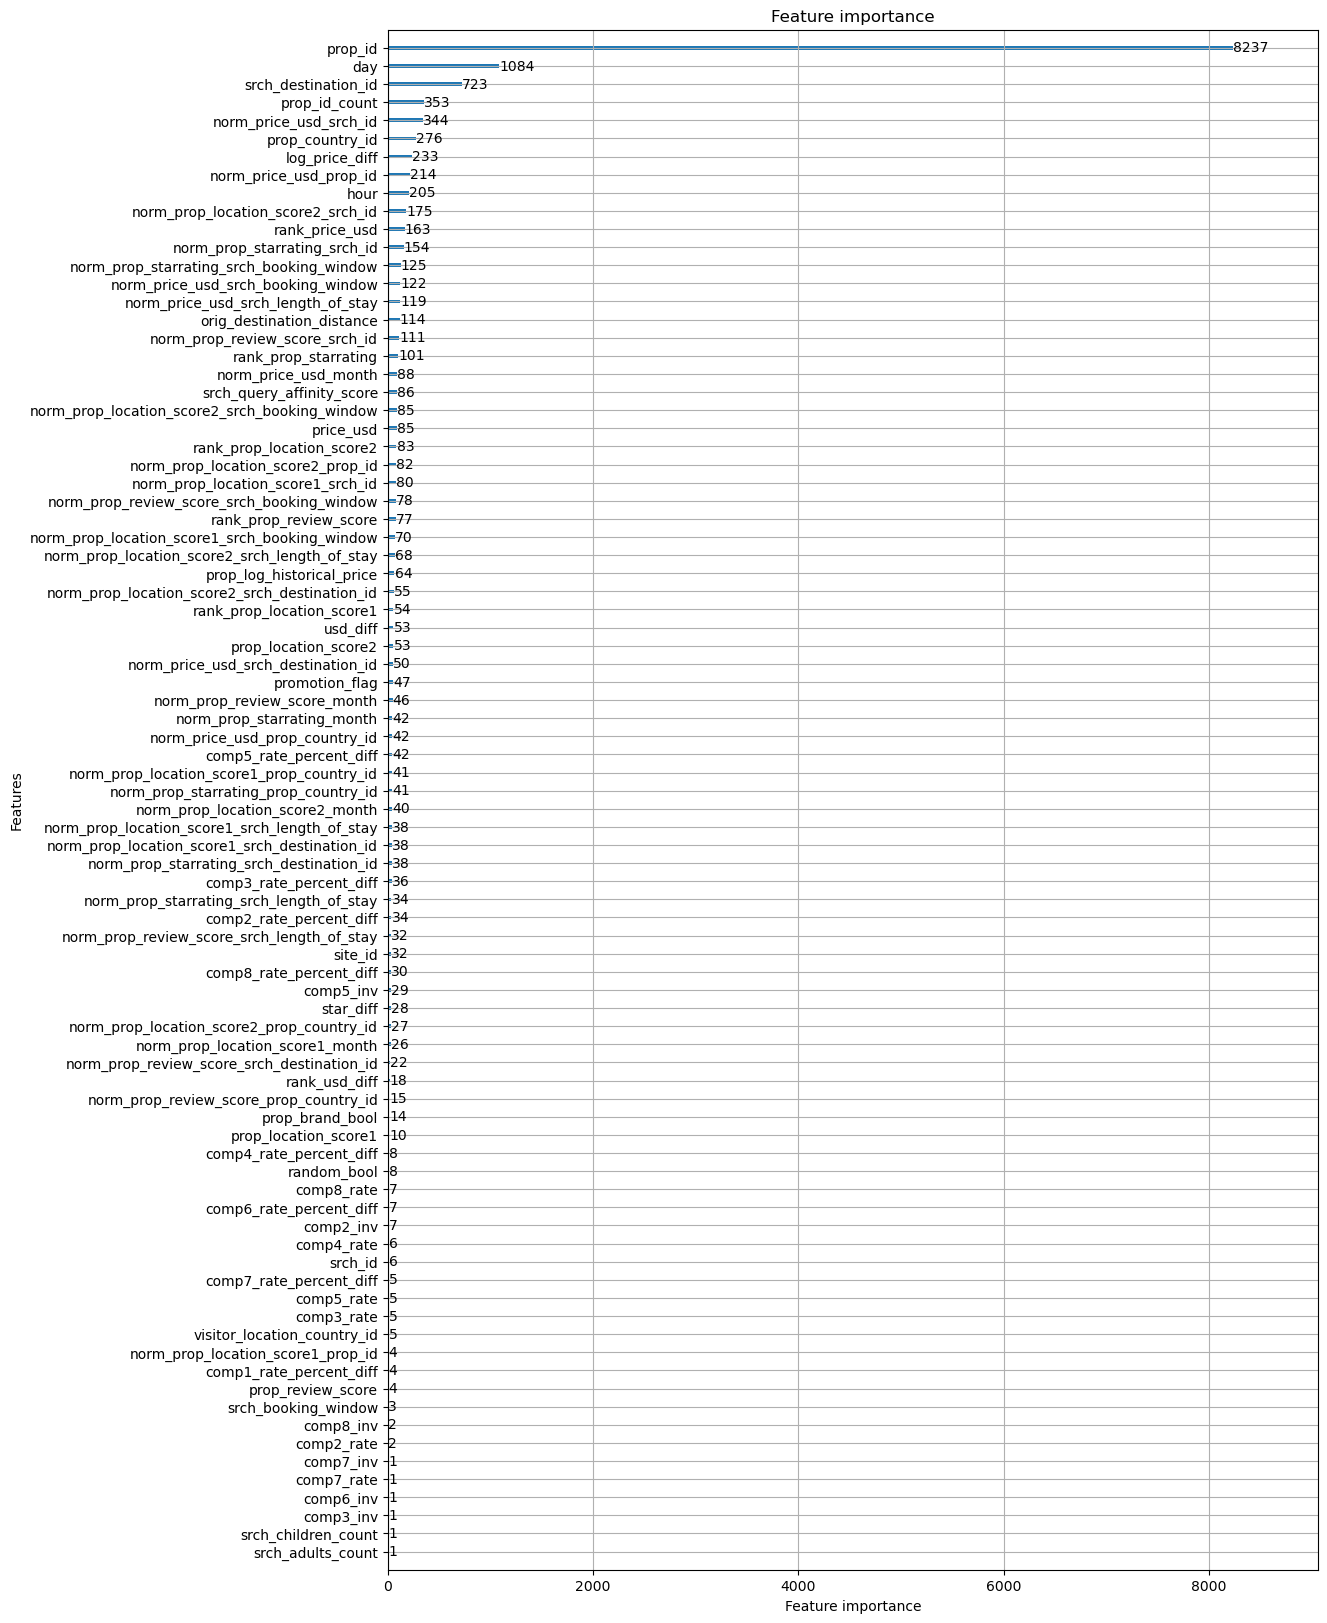

In [13]:
lgb.plot_importance(ranker, figsize = (12,20))